### Introduction

Personality traits like extroversion and introversion shape how individuals interact with their social environments. This dataset provides insights into behaviors such as time spent alone, social event attendance, and social media engagement, enabling applications in psychology, sociology, marketing, and machine learning

In [44]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb

In [20]:
class CFG:
    train_path = '../data/pgseries-s05e07/train.csv'
    test_path = '../data/pgseries-s05e07/test.csv'
    sub_path = '../data/pgseries-s05e07/sample_submission.csv'
    target = 'Personality'
    n_folds = 5
    seed = 42
    cv = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)
    metric = accuracy_score
    n_optuna_trials = 500

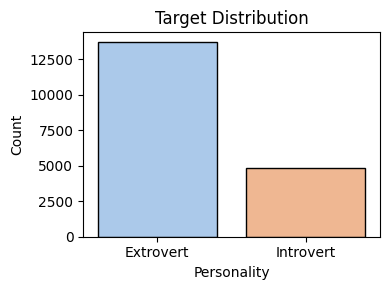

The Value counts of Personality : 

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64


Missing values in train:  0
The column datatype to ascertain category cols : 

Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object


In [40]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')
submissions = pd.read_csv(CFG.sub_path, index_col='id')

plt.figure(figsize=(4, 3)) # setting size of figure.
sns.countplot(x='Personality', data=train, palette='pastel', edgecolor='black')
plt.title('Target Distribution', fontsize=12)
plt.xlabel('Personality', fontsize=10)
plt.ylabel('Count', fontsize=10)

plt.tight_layout()
plt.show()

print(f"The Value counts of Personality : \n\n{train['Personality'].value_counts()}\n")

# EDA: Missing Values - Use of CatBoost, LGBM, XG Boost can handle NaNs
print("\nMissing values in train: ", train['Personality'].isnull().sum())

print(f"The column datatype to ascertain category cols : \n\n{train.dtypes}")


In [45]:
# 3. Encode Target.
# Categorical variable `personality` -> numerical using LabelEncoder
# Encode target labels with value between 0 and n_classes-1.
# This transformer should be used to encode target values, *i.e.* y, and not the input X

le = LabelEncoder()
train["Personality_encoded"] = le.fit_transform(train["Personality"])

# 4. Prepare Features
X = train.drop(columns=["Personality", "Personality_encoded"])
y = train["Personality_encoded"]
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

X_test = test.copy()
print(f"Shape of X Test: {X_test.shape}")

# 5. Encode Categorical Columns Using Ordinal Encoder
cat_cols = X.select_dtypes(include='object').columns.tolist()
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_transformer, cat_cols)
])

X_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(X_test)

Shape of X: (18524, 7)
Shape of y: (18524,)
Shape of X Test: (6175, 7)


In [46]:
# 6. Setup Hyperparameters to XG Boost
params = {
    "objective": "binary:logistic", # as binary classification task, (extro vs intro)
    "eval_metric": "logloss", # metric for binary classifications
    "max_depth": 4, # depth of each decision tree
    "eta": 0.1, # learning rate set to 0.1
    "subsample": 0.8, 
    "colsample_bytree": 0.8,
    "random_state": 42 # for reproducibility
}

In [ ]:
# 7. Stratified K-Fold Cross Validation
# To Train & Validate XG Boost Model, 
# Stratified -> Ensuring Class Dist in each fold remain consistent

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # split in 5 folds
oof_preds = np.zeros(len(X_preprocessed)) # array out of fold prediction for training sets
test_preds = np.zeros(len(X_test_preprocessed)) # stored averaged predictions for test set

for fold, (train_idx, val_idx) in enumerate(skf.split(X_preprocessed,y)):
    X_train, X_val = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    model = xgb.train(params, dtrain, num_boost_round=100,
                       evals=[(dval, "valid")],
                       early_stopping_rounds=10, verbose_eval=False)
    
    oof_preds[val_idx] = model.predict(dval) > 0.5
    test_preds += model.predict(dtest) / skf.n_splits



In [26]:
# 8. Evaluate
cv_acc = accuracy_score(y, oof_preds)
print(f"Cross-Validation Accuracy: {cv_acc:.4f}")

# 9. Create Submission
final_preds = (test_preds > 0.5).astype(int)
submissions["Personality"] = le.inverse_transform(final_preds)
submissions.head()


Cross-Validation Accuracy: 0.9692


,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
